GANs Text2Image Model


Importing Libraries

Loading the dataset


In [303]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
import time
drive.mount('/content/drive')
dataset = np.load('drive/MyDrive/Text2image_dataset/Images.npy', encoding='bytes', allow_pickle = True)
captions = pd.read_csv('drive/MyDrive/Text2image_dataset/captions.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Analyzing/Visualising of data

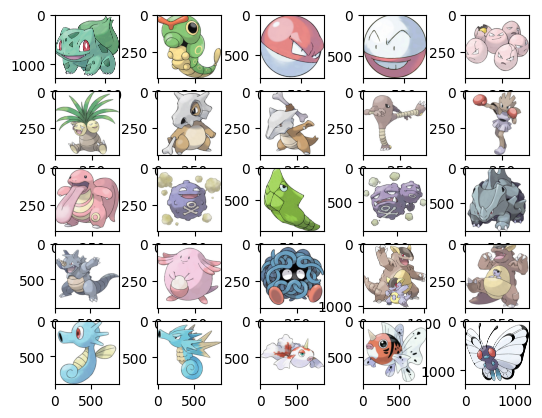

In [304]:
import matplotlib.pyplot as plt
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(dataset[i])


In [305]:
captions.head()

,caption
0,a drawing of a green pokemon with red eyes
1,a green and yellow toy with a red nose
2,a red and white ball with an angry look on its...
3,a cartoon ball with a smile on it's face
4,a bunch of balls with faces drawn on them


Vectorization of texts


In [306]:
sentences = captions['caption']

In [307]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = 10000 , oov_token = "<OOV>")
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

print(word_index)
#print(sequences)

{'<OOV>': 1, 'a': 2, 'with': 3, 'of': 4, 'cartoon': 5, 'and': 6, 'drawing': 7, 'character': 8, 'on': 9, 'blue': 10, 'white': 11, 'pokemon': 12, 'yellow': 13, 'eyes': 14, 'its': 15, 'green': 16, 'big': 17, 'bird': 18, 'pink': 19, 'black': 20, 'red': 21, 'the': 22, 'head': 23, 'animal': 24, 'air': 25, 'flying': 26, 'in': 27, 'looking': 28, 'very': 29, 'cute': 30, 'through': 31, 'his': 32, 'dragon': 33, 'mouth': 34, 'picture': 35, 'top': 36, "it's": 37, 'purple': 38, 'cat': 39, 'face': 40, 'holding': 41, 'wings': 42, 'open': 43, 'hat': 44, 'sitting': 45, 'smile': 46, 'an': 47, 'it': 48, 'tail': 49, 'type': 50, 'butterfly': 51, 'nose': 52, 'ball': 53, 'beak': 54, 'orange': 55, 'is': 56, 'fish': 57, 'horns': 58, 'background': 59, 'leaf': 60, 'back': 61, 'object': 62, 'brown': 63, 'flower': 64, 'two': 65, 'pikachu': 66, 'gray': 67, 'hair': 68, 'creature': 69, 'long': 70, 'large': 71, 'look': 72, 'image': 73, 'standing': 74, 'star': 75, 'crown': 76, 'dog': 77, 'around': 78, 'neck': 79, 'robot

In [310]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [311]:
def pad_array_to_size_16(arr):
    if len(arr) >= 16:
        return arr

    padding_size = 16 - len(arr)
    padded_array = [0] * padding_size + arr
    return padded_array

#this function takes a string as input and converts it into 16 dimensional array
def process_sentence(sentence):
  sequence = flatten_list(tokenizer.texts_to_sequences([sentence]))
  sequence_padded = pad_array_to_size_16(sequence)
  sequence_array = np.array(sequence_padded)
  return np.float64(sequence_array)



In [312]:
pad_array_to_size_16([1,2,3,4])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4]

In [313]:
vector = process_sentence("a cartoon ball with a smile on it's face")
vector

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  5., 53.,  3.,  2., 46.,
        9., 37., 40.])

In [314]:
#this function takes a list of strings as input and converts them into 16 dimensional arrays
def process_sentence_many(sentences):
  sequences = []
  for sentence in sentences:
    sequences.append(process_sentence(sentence))
  return sequences

In [315]:
text_vectors = process_sentence_many(sentences)
text_vectors[:5]

[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  7.,  4.,  2., 16., 12.,
         3., 21., 14.]),
 array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,  16.,   6.,  13.,
        141.,   3.,   2.,  21.,  52.]),
 array([  0.,   0.,   0.,   0.,   2.,  21.,   6.,  11.,  53.,   3.,  47.,
        123.,  72.,   9.,  15.,  40.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  5., 53.,  3.,  2., 46.,
         9., 37., 40.]),
 array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   2., 226.,   4., 142.,
          3., 227., 228.,   9., 165.])]

Pre-Processing of Data


In [318]:
images = []
for i in range(len(dataset)):
  images.append(tf.image.resize(dataset[i], (128,128)))
images = np.array(images)

In [319]:
images.shape

(833, 128, 128, 3)

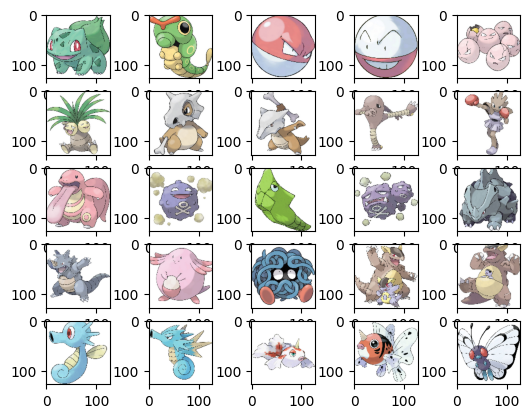

In [320]:
import matplotlib.pyplot as plt
#print(dataset[0])
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(images[i].astype('uint8'))

Generator

In [321]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(32 * 32 * 256, use_bias=False, input_shape=(116,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((32, 32, 256)))
    assert model.output_shape == (None, 32, 32, 256)

    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

Discriminator

In [322]:
from tensorflow.python.ops.gen_nn_ops import Relu
from tensorflow import keras
def make_discriminator_model():
  Discriminator = tf.keras.Sequential()
  Discriminator.add(keras.layers.Conv2D(64, (10, 10), input_shape = (128, 128, 3), strides = (2, 2), padding = 'same'))
  print(Discriminator.summary())
  Discriminator.add(keras.layers.LeakyReLU())
  Discriminator.add(keras.layers.Conv2D(128, (10, 10), strides = (2, 2), padding = 'same'))
  Discriminator.add(keras.layers.LeakyReLU())
  Discriminator.add(keras.layers.Conv2D(256, (10, 10), strides = (2, 2), padding = 'same'))
  Discriminator.add(keras.layers.LeakyReLU())
  Discriminator.add(keras.layers.Flatten())
  Discriminator.add(keras.layers.Dense(1, activation = 'sigmoid'))
  return Discriminator


In [323]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(Real, Fake):
  real_loss = cross_entropy(tf.ones_like(Real), Real)
  fake_loss = cross_entropy(tf.zeros_like(Fake), Fake)
  return real_loss + fake_loss
def generator_loss(fake):
  return cross_entropy(tf.ones_like(fake), fake)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [324]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

generator = make_generator_model()
generator.summary()
discriminator = make_discriminator_model()
discriminator.summary()
EPOCHS = 26
noise_dim = 100
num_examples_to_generate = 1
BATCH_SIZE = 1
text = 'a cartoon ball with a smile on its face'

def text_to_tensor(text,size):
  text_vector = process_sentence(text)
  text_vector = tf.expand_dims(text_vector.astype(float), axis=0)
  noise = tf.random.normal([size, noise_dim])
  noise = tf.cast(noise, tf.float64)
  conc = tf.concat([noise, text_vector], axis=-1)
  return conc

seed = text_to_tensor(text,num_examples_to_generate)

@tf.function
def train_step(images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      conc = text_to_tensor(text,BATCH_SIZE)
      generated_images = generator(conc, training=True)
      generated_images = tf.image.resize(generated_images, (128,128))
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 262144)            30408704  
                                                                 
 batch_normalization_37 (Bat  (None, 262144)           1048576   
 chNormalization)                                                
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 262144)            0         
                                                                 
 reshape_13 (Reshape)        (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_36 (Conv2D  (None, 64, 64, 128)      819200    
 Transpose)                                                      
                                                                 
 batch_normalization_38 (Bat  (None, 64, 64, 128)    

Training

In [325]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
      plt.subplot(6, 6, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [326]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [327]:
def train(dataset, epochs):
  k = 1
  for epoch in range(epochs):

    for image_batch in dataset:
      image_batch = np.expand_dims(image_batch, axis=0)
      train_step(image_batch)

    print(k)
    k += 1
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)


    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  generate_and_save_images(generator,
                           epochs,
                           seed)

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1


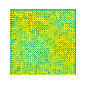

2


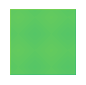

3


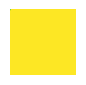

4


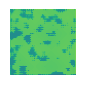

5


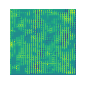

6


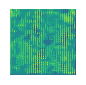

7


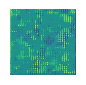

8


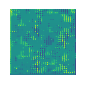

9


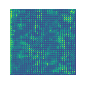

10


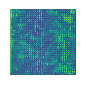

11


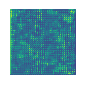

12


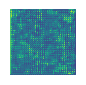

13


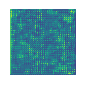

14


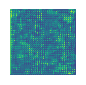

15


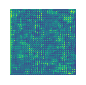

16


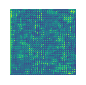

17


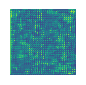

18


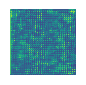

19


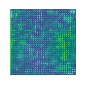

20


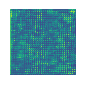

21


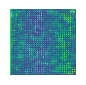

22


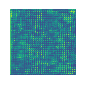

23


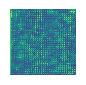

24


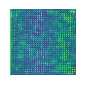

25


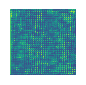

26


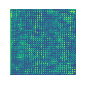

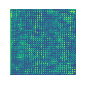

In [328]:
train(images, EPOCHS)